In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# mdates
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import scikits.bootstrap as bootstrap
# t test
from scipy.stats import ttest_ind

In [2]:
def mean_bootstrap(x, f, nsim=1000, **kwargs):
    """
    
    Params:
    x, y - data (numpy arrays)
    f - test function to calculate
    nsim - number of simulations to run
    """
    statistic = np.zeros(nsim)
    for i in range(nsim):
        # simulate x
        indices = np.random.randint(0, len(x), len(x))
        X = x[indices]
        X += np.random.normal(0, 0.05, len(x))

        statistic[i] = f(X, **kwargs)

    return statistic

In [3]:
df_prec = pd.read_csv('df_prec_ALL_AMZ.csv', sep=',')
df_temp = pd.read_csv('df_temp_ALL_AMZ.csv', sep=',')

In [4]:
# Change the format of the time column
df_prec['time'] = pd.to_datetime(df_prec['time'], format='%Y-%m-%d')
df_prec['year'] = df_prec['time'].dt.year

df_temp['time'] = pd.to_datetime(df_temp['time'], format='%Y-%m-%d')
df_temp['year'] = df_temp['time'].dt.year

In [5]:
df_prec.loc[(df_prec['year'] >= 1979) & (df_prec['year'] <= 1999), 'Period'] = '1979-1999'
df_prec.loc[(df_prec['year'] >= 2000) & (df_prec['year'] <= 2020), 'Period'] = '2000-2020'

df_temp.loc[(df_temp['year'] >= 1979) & (df_temp['year'] <= 1999), 'Period'] = '1979-1999'
df_temp.loc[(df_temp['year'] >= 2000) & (df_temp['year'] <= 2020), 'Period'] = '2000-2020'

In [6]:
df_prec.columns

Index(['time', 'cdd', 'cwd', 'prcptot', 'r10mm', 'r20mm', 'r30mm', 'r95p',
       'r99p', 'rx1day', 'rx5day', 'sdii', 'year', 'Period'],
      dtype='object')

In [7]:
# Calc mean bootstrap
meanx_I = mean_bootstrap(df_prec.loc[df_prec['Period'] == '1979-1999', 'cdd'].values, np.mean)
meanx_II = mean_bootstrap(df_prec.loc[df_prec['Period'] == '2000-2020', 'cdd'].values, np.mean)
# # Calculate the 95% confidence interval
ci_meanx_I = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '1979-1999', 'cdd'].values, statfunction=np.mean, n_samples=1000)
ci_meanx_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'cdd'].values, statfunction=np.mean, n_samples=1000)

In [8]:
# apply t test
alpha = 0.05
t, p = ttest_ind(meanx_I, meanx_II)
if p < alpha:
    print('The means are different')
else:
    print('The means are equal')

The means are different


In [9]:
# Create a dataframe
df_stats_I = pd.DataFrame({'mean': meanx_I, 'Período': '1979-1999'})
df_stats_II = pd.DataFrame({'mean': meanx_II, 'Período': '2000-2020'})

df_stats = pd.concat([df_stats_I, df_stats_II])

# # Calculate the 95% confidence interval
ci = bootstrap.ci(data=df_stats['mean'].values, statfunction=np.mean, n_samples=1000)

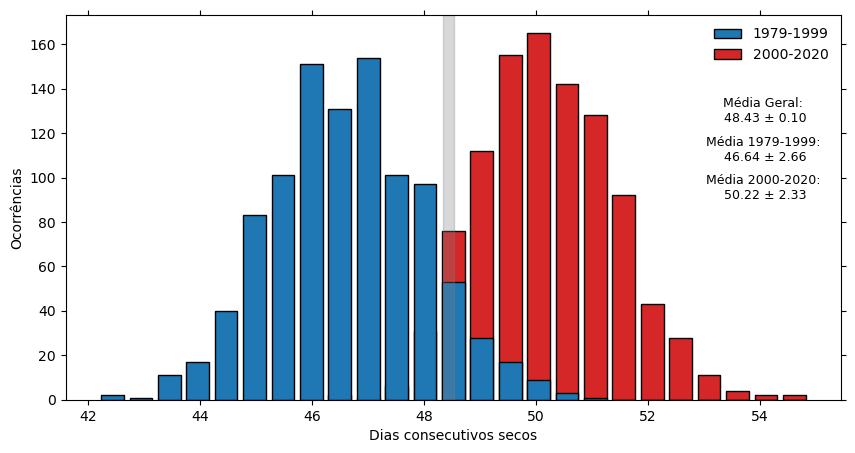

In [10]:
# Plot the histogram of precipitation
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df_stats, x='mean', hue='Período', kde=False, 
             ax=ax, bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=True)

# Remove frameon and title of legend
ax.get_legend().set_title('')
ax.get_legend().set_frame_on(False)



ax.set_xlabel('Dias consecutivos secos')
ax.set_ylabel('Ocorrências')
# Axvspan to plot the confidence interval
ax.axvspan(ci[0], ci[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax.text(0.90, 0.75, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats['mean'].mean(),
                                                    (ci[1] - ci[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax.text(0.90, 0.65, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats.loc[df_stats['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_meanx_I[1] - ci_meanx_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax.text(0.90, 0.55, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats.loc[df_stats['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_meanx_II[1] - ci_meanx_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=9)


# Set ticks
ax.tick_params(axis='both', which='major', top=True, right=True)


# Save figure
# fig.savefig('hist_cdd.png', dpi=600, bbox_inches='tight', facecolor='white')

In [63]:
# Open data of precipitation and temperature
df = pd.read_csv('Prec_Temp_mon_AMZ.csv', sep=',')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
# Set time index
df.set_index('time', inplace=True)

# Get prec and temp
df_prec_mon = df[['Prec_NWS', 'Prec_NSA', 'Prec_SAM', 'Prec_NES']]
df_temp_mon = df[['Temp_NWS', 'Temp_NSA', 'Temp_SAM', 'Temp_NES']]


# Resample to anual
df_anual_prec = df_prec_mon.resample('1Y').sum()
df_anual_temp = df_temp_mon.resample('1Y').mean()

In [64]:
# melt the dataframe
df_anual_prec_melt = df_anual_prec.melt(ignore_index=False, var_name='Region', value_name='Prec')
df_anual_prec_melt['year'] = df_anual_prec_melt.index.year
df_anual_temp_melt = df_anual_temp.melt(ignore_index=False, var_name='Region', value_name='Temp')
df_anual_temp_melt['year'] = df_anual_temp_melt.index.year

## Precipitação

In [30]:
# CDD
# Calc mean bootstrap
meanx_cdd_I = mean_bootstrap(df_prec.loc[df_prec['Period'] == '1979-1999', 'cdd'].values, np.mean)
meanx_cdd_II = mean_bootstrap(df_prec.loc[df_prec['Period'] == '2000-2020', 'cdd'].values, np.mean)
# # Calculate the 95% confidence interval
ci_cdd_I = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '1979-1999', 'cdd'].values, statfunction=np.mean, n_samples=1000)
ci_cdd_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'cdd'].values, statfunction=np.mean, n_samples=1000)

# CWD
# Calc mean bootstrap
meanx_cwd_I = mean_bootstrap(df_prec.loc[df_prec['Period'] == '1979-1999', 'cwd'].values, np.mean)
meanx_cwd_II = mean_bootstrap(df_prec.loc[df_prec['Period'] == '2000-2020', 'cwd'].values, np.mean)
# # Calculate the 95% confidence interval
ci_cwd_I = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '1979-1999', 'cwd'].values, statfunction=np.mean, n_samples=1000)
ci_cwd_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'cwd'].values, statfunction=np.mean, n_samples=1000)

# SDII
# Calc mean bootstrap
meanx_sdii_I = mean_bootstrap(df_prec.loc[df_prec['Period'] == '1979-1999', 'sdii'].values, np.mean)
meanx_sdii_II = mean_bootstrap(df_prec.loc[df_prec['Period'] == '2000-2020', 'sdii'].values, np.mean)
# # Calculate the 95% confidence interval
ci_sdii_I = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '1979-1999', 'sdii'].values, statfunction=np.mean, n_samples=1000)
ci_sdii_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'sdii'].values, statfunction=np.mean, n_samples=1000)

# Rx1day
# Calc mean bootstrap
meanx_rx1day_I = mean_bootstrap(df_prec.loc[df_prec['Period'] == '1979-1999', 'rx1day'].values, np.mean)
meanx_rx1day_II = mean_bootstrap(df_prec.loc[df_prec['Period'] == '2000-2020', 'rx1day'].values, np.mean)
# # Calculate the 95% confidence interval
ci_rx1day_I = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '1979-1999', 'rx1day'].values, statfunction=np.mean, n_samples=1000)
ci_rx1day_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'rx1day'].values, statfunction=np.mean, n_samples=1000)

C:\Users\Luiz\AppData\Local\Temp\ipykernel_5900\1259312324.py:15: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  ci_cwd_II = bootstrap.ci(data=df_prec.loc[df_prec['Period'] == '2000-2020', 'cwd'].values, statfunction=np.mean, n_samples=1000)


In [31]:
# Create dataframe CDD
df_stats_cdd_I = pd.DataFrame({'mean': meanx_cdd_I, 'Período': '1979-1999'})
df_stats_cdd_II = pd.DataFrame({'mean': meanx_cdd_II, 'Período': '2000-2020'})
df_stats_cdd = pd.concat([df_stats_cdd_I, df_stats_cdd_II])
# # Calculate the 95% confidence interval
ci_cdd = bootstrap.ci(data=df_stats_cdd['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe CWD
df_stats_cwd_I = pd.DataFrame({'mean': meanx_cwd_I, 'Período': '1979-1999'})
df_stats_cwd_II = pd.DataFrame({'mean': meanx_cwd_II, 'Período': '2000-2020'})
df_stats_cwd = pd.concat([df_stats_cwd_I, df_stats_cwd_II])
# # Calculate the 95% confidence interval
ci_cwd = bootstrap.ci(data=df_stats_cwd['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe SDII
df_stats_sdii_I = pd.DataFrame({'mean': meanx_sdii_I, 'Período': '1979-1999'})
df_stats_sdii_II = pd.DataFrame({'mean': meanx_sdii_II, 'Período': '2000-2020'})
df_stats_sdii = pd.concat([df_stats_sdii_I, df_stats_sdii_II])
# # Calculate the 95% confidence interval
ci_sdii = bootstrap.ci(data=df_stats_sdii['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe Rx1day
df_stats_rx1day_I = pd.DataFrame({'mean': meanx_rx1day_I, 'Período': '1979-1999'})
df_stats_rx1day_II = pd.DataFrame({'mean': meanx_rx1day_II, 'Período': '2000-2020'})
df_stats_rx1day = pd.concat([df_stats_rx1day_I, df_stats_rx1day_II])
# # Calculate the 95% confidence interval
ci_rx1day = bootstrap.ci(data=df_stats_rx1day['mean'].values, statfunction=np.mean, n_samples=1000)

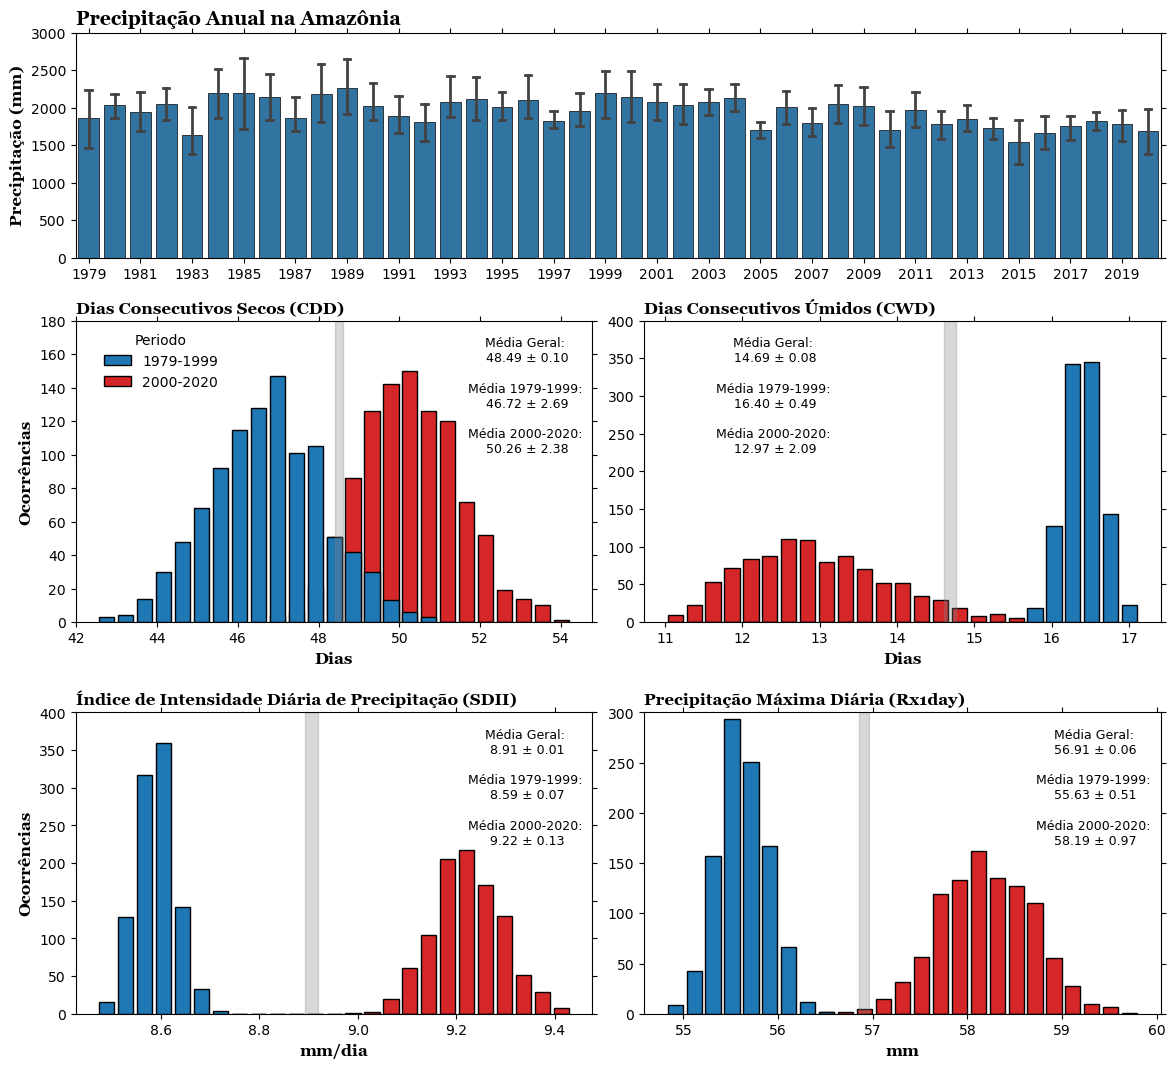

In [122]:
fig, ax = plt.subplots(figsize=(14, 9), ncols=2, nrows=2, sharex=False, sharey=False, gridspec_kw={'wspace': 0.1, 'hspace': 0.3})
ax = ax.flatten()

# CDD
sns.histplot(data=df_stats_cdd, x='mean', hue='Período', kde=False,
                ax=ax[0], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=True)
ax[0].set_title('Dias Consecutivos Secos (CDD)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[0].set_xlabel('Dias', fontsize=12, fontname='Georgia', fontweight='bold')
ax[0].set_ylabel('Ocorrências', fontsize=12, fontname='Georgia', fontweight='bold')
# Axvspan to plot the confidence interval
ax[0].axvspan(ci_cdd[0], ci_cdd[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[0].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cdd['mean'].mean(),
                                                    (ci_cdd[1] - ci_cdd[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[0].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cdd_I.loc[
    df_stats_cdd_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_cdd_I[1] - ci_cdd_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[0].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cdd_II.loc[
    df_stats_cdd_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_cdd_II[1] - ci_cdd_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)

# CWD
sns.histplot(data=df_stats_cwd, x='mean', hue='Período', kde=False,
                ax=ax[1], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[1].set_title('Dias Consecutivos Úmidos (CWD)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[1].set_xlabel('Dias', fontsize=12, fontweight='bold', fontname='Georgia')
ax[1].set_ylabel('')
# Axvspan to plot the confidence interval
ax[1].axvspan(ci_cwd[0], ci_cwd[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[1].text(0.25, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cwd['mean'].mean(),
                                                    (ci_cwd[1] - ci_cwd[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[1].text(0.25, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cwd_I.loc[
    df_stats_cwd_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_cwd_I[1] - ci_cwd_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[1].text(0.25, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_cwd_II.loc[
    df_stats_cwd_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_cwd_II[1] - ci_cwd_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)

# SDII
sns.histplot(data=df_stats_sdii, x='mean', hue='Período', kde=False,
                ax=ax[2], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[2].set_title('Índice de Intensidade Diária de Precipitação (SDII)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[2].set_xlabel('mm/dia', fontsize=12, fontweight='bold', fontname='Georgia')
ax[2].set_ylabel('Ocorrências', fontsize=12, fontweight='bold', fontname='Georgia')
# Axvspan to plot the confidence interval
ax[2].axvspan(ci_sdii[0], ci_sdii[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[2].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_sdii['mean'].mean(),
                                                    (ci_sdii[1] - ci_sdii[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[2].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_sdii_I.loc[
    df_stats_sdii_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_sdii_I[1] - ci_sdii_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[2].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_sdii_II.loc[
    df_stats_sdii_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_sdii_II[1] - ci_sdii_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)

# Rx1day
sns.histplot(data=df_stats_rx1day, x='mean', hue='Período', kde=False,
                ax=ax[3], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[3].set_title('Precipitação Máxima Diária (Rx1day)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[3].set_xlabel('mm', fontsize=12, fontweight='bold', fontname='Georgia')
ax[3].set_ylabel('')
# Axvspan to plot the confidence interval
ax[3].axvspan(ci_rx1day[0], ci_rx1day[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[3].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_rx1day['mean'].mean(),
                                                    (ci_rx1day[1] - ci_rx1day[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[3].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_rx1day_I.loc[
    df_stats_rx1day_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_rx1day_I[1] - ci_rx1day_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[3].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_rx1day_II.loc[
    df_stats_rx1day_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_rx1day_II[1] - ci_rx1day_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)

# Manual set ylim
ax[0].set_ylim(0, 180)
ax[1].set_ylim(0, 400)
ax[2].set_ylim(0, 400)
ax[3].set_ylim(0, 300)

# Add axis to barplot
ax_bar = fig.add_axes([0.125, 0.95, 0.775, 0.25]) # x0, y0, width, height
# seaborn barplot
sns.barplot(data=df_anual_prec_melt,x='year', y='Prec', color='tab:blue', alpha=1, ax=ax_bar,
            edgecolor='black', linewidth=0.5, errwidth=2., capsize=0.25)
# change freq of xticks labels to 2 and 2 
ax_bar.xaxis.set_major_locator(ticker.MultipleLocator(2))



# # Set xticks
# ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=0, fontsize=9, fontweight='bold', fontname='Georgia')                 

# Ticks params
for i in range(4):
    ax[i].tick_params(axis='both', which='major', top=True, right=True)

ax_bar.tick_params(axis='both', which='major', top=True, right=True)
ax_bar.set_ylim(0, 3000)

# Labels
ax_bar.set_xlabel('', fontsize=12, fontweight='bold', fontname='Georgia')
ax_bar.set_ylabel('Precipitação (mm)', fontsize=12, fontweight='bold', fontname='Georgia')
ax_bar.set_title('Precipitação Anual na Amazônia', fontsize=14, fontweight='bold', loc='left', fontname='Georgia')

# Legend
# Remove frameon and title of legend
ax[0].get_legend().set_title('Periodo')
ax[0].get_legend().set_frame_on(False)
# Move legend to the right
ax[0].get_legend().set_bbox_to_anchor((0.30, 1))
# Set to 1 column


# Save figure
fig.savefig('Precipitation.png', dpi=600, bbox_inches='tight', facecolor='white')


## Temperatura

In [82]:
# TX90p
# Calc mean bootstrap
meanx_tx90p_I = mean_bootstrap(df_temp.loc[df_temp['Period'] == '1979-1999', 'tx90p'].values, np.mean)
meanx_tx90p_II = mean_bootstrap(df_temp.loc[df_temp['Period'] == '2000-2020', 'tx90p'].values, np.mean)
# # Calculate the 95% confidence interval
ci_tx90p_I = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '1979-1999', 'tx90p'].values, statfunction=np.mean, n_samples=1000)
ci_tx90p_II = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '2000-2020', 'tx90p'].values, statfunction=np.mean, n_samples=1000)

# TN90p
# Calc mean bootstrap
meanx_tn90p_I = mean_bootstrap(df_temp.loc[df_temp['Period'] == '1979-1999', 'tn90p'].values, np.mean)
meanx_tn90p_II = mean_bootstrap(df_temp.loc[df_temp['Period'] == '2000-2020', 'tn90p'].values, np.mean)
# # Calculate the 95% confidence interval
ci_tn90p_I = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '1979-1999', 'tn90p'].values, statfunction=np.mean, n_samples=1000)
ci_tn90p_II = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '2000-2020', 'tn90p'].values, statfunction=np.mean, n_samples=1000)

# TX10p
# Calc mean bootstrap
meanx_tx10p_I = mean_bootstrap(df_temp.loc[df_temp['Period'] == '1979-1999', 'tx10p'].values, np.mean)
meanx_tx10p_II = mean_bootstrap(df_temp.loc[df_temp['Period'] == '2000-2020', 'tx10p'].values, np.mean)
# # Calculate the 95% confidence interval
ci_tx10p_I = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '1979-1999', 'tx10p'].values, statfunction=np.mean, n_samples=1000)
ci_tx10p_II = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '2000-2020', 'tx10p'].values, statfunction=np.mean, n_samples=1000)

# TN10p
# Calc mean bootstrap
meanx_tn10p_I = mean_bootstrap(df_temp.loc[df_temp['Period'] == '1979-1999', 'tn10p'].values, np.mean)
meanx_tn10p_II = mean_bootstrap(df_temp.loc[df_temp['Period'] == '2000-2020', 'tn10p'].values, np.mean)
# # Calculate the 95% confidence interval
ci_tn10p_I = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '1979-1999', 'tn10p'].values, statfunction=np.mean, n_samples=1000)
ci_tn10p_II = bootstrap.ci(data=df_temp.loc[df_temp['Period'] == '2000-2020', 'tn10p'].values, statfunction=np.mean, n_samples=1000)


In [83]:
# Create dataframe TX90p
df_stats_tx90p_I = pd.DataFrame({'mean': meanx_tx90p_I, 'Período': '1979-1999'})
df_stats_tx90p_II = pd.DataFrame({'mean': meanx_tx90p_II, 'Período': '2000-2020'})
df_stats_tx90p = pd.concat([df_stats_tx90p_I, df_stats_tx90p_II])
# # Calculate the 95% confidence interval
ci_tx90p = bootstrap.ci(data=df_stats_tx90p['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe TN90p
df_stats_tn90p_I = pd.DataFrame({'mean': meanx_tn90p_I, 'Período': '1979-1999'})
df_stats_tn90p_II = pd.DataFrame({'mean': meanx_tn90p_II, 'Período': '2000-2020'})
df_stats_tn90p = pd.concat([df_stats_tn90p_I, df_stats_tn90p_II])
# # Calculate the 95% confidence interval
ci_tn90p = bootstrap.ci(data=df_stats_tn90p['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe TX10p
df_stats_tx10p_I = pd.DataFrame({'mean': meanx_tx10p_I, 'Período': '1979-1999'})
df_stats_tx10p_II = pd.DataFrame({'mean': meanx_tx10p_II, 'Período': '2000-2020'})
df_stats_tx10p = pd.concat([df_stats_tx10p_I, df_stats_tx10p_II])
# # Calculate the 95% confidence interval
ci_tx10p = bootstrap.ci(data=df_stats_tx10p['mean'].values, statfunction=np.mean, n_samples=1000)

# Create dataframe TN10p
df_stats_tn10p_I = pd.DataFrame({'mean': meanx_tn10p_I, 'Período': '1979-1999'})
df_stats_tn10p_II = pd.DataFrame({'mean': meanx_tn10p_II, 'Período': '2000-2020'})
df_stats_tn10p = pd.concat([df_stats_tn10p_I, df_stats_tn10p_II])
# # Calculate the 95% confidence interval
ci_tn10p = bootstrap.ci(data=df_stats_tn10p['mean'].values, statfunction=np.mean, n_samples=1000)

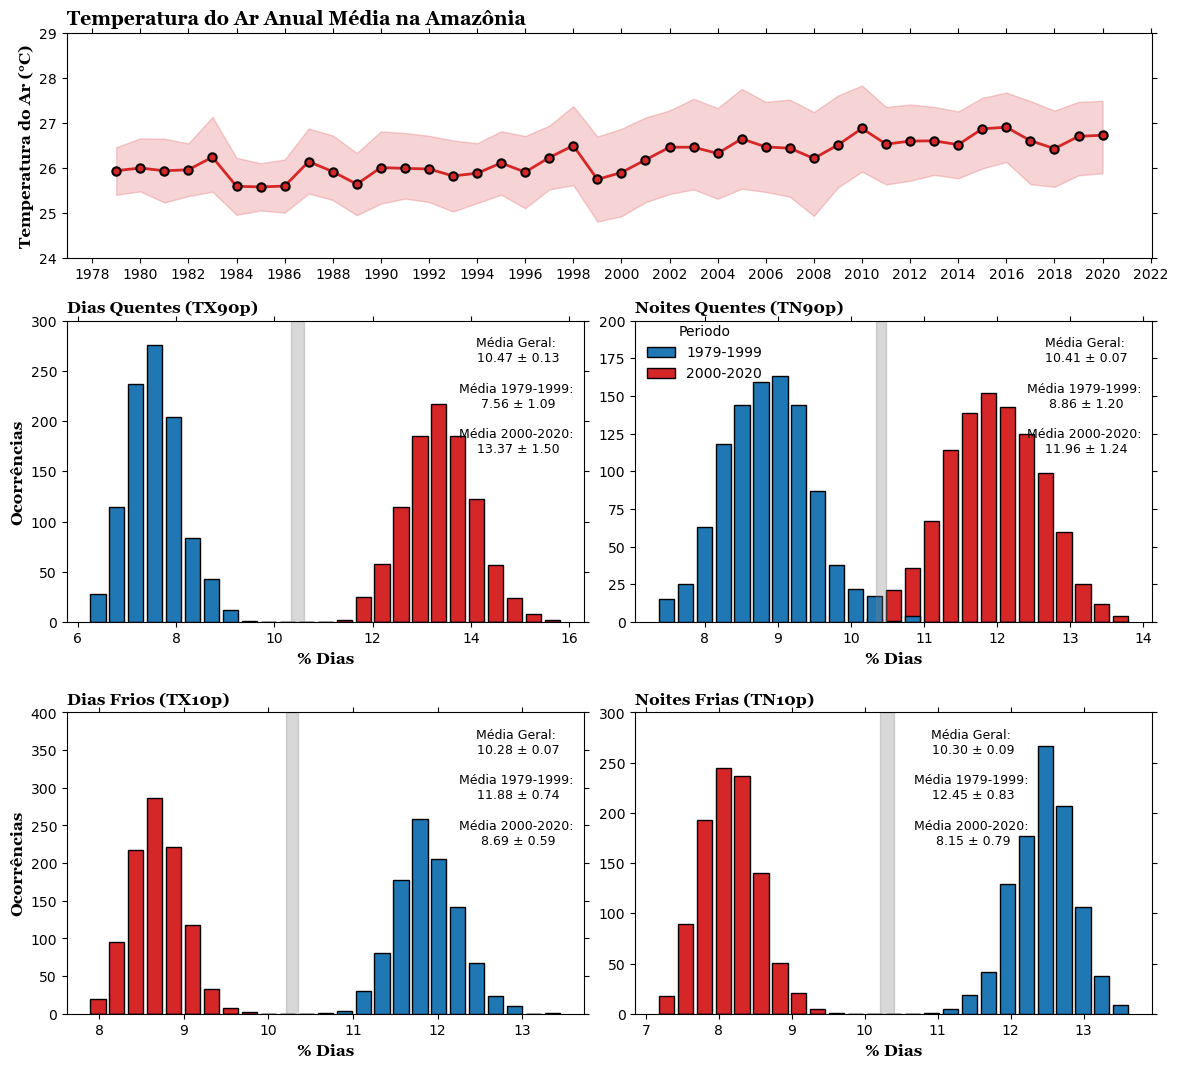

In [121]:
fig, ax = plt.subplots(figsize=(14, 9), ncols=2, nrows=2, sharex=False, sharey=False, gridspec_kw={'wspace': 0.1, 'hspace': 0.3})
ax = ax.flatten()

# TX90p
sns.histplot(data=df_stats_tx90p, x='mean', hue='Período', kde=False,
                ax=ax[0], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[0].set_title('Dias Quentes (TX90p)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[0].set_xlabel('% Dias', fontsize=12, fontname='Georgia', fontweight='bold')
ax[0].set_ylabel('Ocorrências', fontsize=12, fontname='Georgia', fontweight='bold')
# Axvspan to plot the confidence interval
ax[0].axvspan(ci_tx90p[0], ci_tx90p[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[0].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx90p['mean'].mean(),
                                                    (ci_tx90p[1] - ci_tx90p[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[0].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx90p_I.loc[
    df_stats_tx90p_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_tx90p_I[1] - ci_tx90p_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[0].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx90p_II.loc[
    df_stats_tx90p_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_tx90p_II[1] - ci_tx90p_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=9)

# TN90p
sns.histplot(data=df_stats_tn90p, x='mean', hue='Período', kde=False,
                ax=ax[1], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=True)
ax[1].set_title('Noites Quentes (TN90p)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[1].set_xlabel('% Dias', fontsize=12, fontname='Georgia', fontweight='bold')
ax[1].set_ylabel('', fontsize=12, fontname='Georgia', fontweight='bold')
# Axvspan to plot the confidence interval
ax[1].axvspan(ci_tn90p[0], ci_tn90p[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[1].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn90p['mean'].mean(),
                                                    (ci_tn90p[1] - ci_tn90p[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[1].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn90p_I.loc[
    df_stats_tn90p_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_tn90p_I[1] - ci_tn90p_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[1].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn90p_II.loc[
    df_stats_tn90p_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_tn90p_II[1] - ci_tn90p_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes, fontsize=9)

# TX10p
sns.histplot(data=df_stats_tx10p, x='mean', hue='Período', kde=False,
                ax=ax[2], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[2].set_title('Dias Frios (TX10p)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[2].set_xlabel('% Dias', fontsize=12, fontname='Georgia', fontweight='bold')
ax[2].set_ylabel('Ocorrências', fontsize=12, fontname='Georgia', fontweight='bold')
# Axvspan to plot the confidence interval
ax[2].axvspan(ci_tx10p[0], ci_tx10p[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[2].text(0.87, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx10p['mean'].mean(),
                                                    (ci_tx10p[1] - ci_tx10p[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[2].text(0.87, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx10p_I.loc[
    df_stats_tx10p_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_tx10p_I[1] - ci_tx10p_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[2].text(0.87, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tx10p_II.loc[
    df_stats_tx10p_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_tx10p_II[1] - ci_tx10p_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=9)

# TN10p
sns.histplot(data=df_stats_tn10p, x='mean', hue='Período', kde=False,
                ax=ax[3], bins=25, palette=['tab:blue', 'tab:red'], alpha=1, shrink=0.8, legend=False)
ax[3].set_title('Noites Frias (TN10p)', fontsize=12, fontweight='bold', loc='left', fontname='Georgia')
ax[3].set_xlabel('% Dias', fontsize=12, fontname='Georgia', fontweight='bold')
ax[3].set_ylabel('', fontsize=12, fontname='Georgia', fontweight='bold')
# Axvspan to plot the confidence interval
ax[3].axvspan(ci_tn10p[0], ci_tn10p[1], alpha=0.3, color='grey')
# Mean +- IC geral
ax[3].text(0.65, 0.90, u'Média Geral:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn10p['mean'].mean(),
                                                    (ci_tn10p[1] - ci_tn10p[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)
# Mean +- IC 1979-1999
ax[3].text(0.65, 0.75, u'Média 1979-1999:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn10p_I.loc[
    df_stats_tn10p_I['Período'] == '1979-1999', 'mean'].mean(),
                                                        (ci_tn10p_I[1] - ci_tn10p_I[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)
# Mean +- IC 2000-2020
ax[3].text(0.65, 0.60, u'Média 2000-2020:\n {:.2f} \u00B1 {:.2f}'.format(df_stats_tn10p_II.loc[
    df_stats_tn10p_II['Período'] == '2000-2020', 'mean'].mean(),
                                                        (ci_tn10p_II[1] - ci_tn10p_II[0])/2),
        horizontalalignment='center', verticalalignment='center', transform=ax[3].transAxes, fontsize=9)

# Manual set ylim
ax[0].set_ylim(0, 300)
ax[1].set_ylim(0, 200)
ax[2].set_ylim(0, 400)
ax[3].set_ylim(0, 300)

# Add axis to barplot
ax_line = fig.add_axes([0.125, 0.95, 0.775, 0.25]) # x0, y0, width, height
# seaborn barplot
sns.lineplot(data=df_anual_temp_melt,x='year', y='Temp', color='tab:red', alpha=1, ax=ax_line,
             linewidth=2., marker='o', markersize=6, markeredgewidth=1.5, markeredgecolor='black')
# change freq of xticks labels to 2 and 2 
ax_line.xaxis.set_major_locator(ticker.MultipleLocator(2))
                
# Ticks params
for i in range(4):
    ax[i].tick_params(axis='both', which='major', top=True, right=True)

ax_line.tick_params(axis='both', which='major', top=True, right=True)
ax_line.set_ylim(24, 29)

# Labels
ax_line.set_xlabel('', fontsize=12, fontweight='bold', fontname='Georgia')
ax_line.set_ylabel('Temperatura do Ar (°C)' 
                  , fontsize=12, fontweight='bold', fontname='Georgia')
ax_line.set_title('Temperatura do Ar Anual Média na Amazônia', fontsize=14, fontweight='bold', loc='left', fontname='Georgia')

# Legend
# Remove frameon and title of legend
ax[1].get_legend().set_title('Periodo')
ax[1].get_legend().set_frame_on(False)
# Move legend to the right
ax[1].get_legend().set_bbox_to_anchor((0.27, 0.76))
# Set to 1 column


# Save figure
fig.savefig('Temperature.png', dpi=600, bbox_inches='tight', facecolor='white')